In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

In [152]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

1. Plot 16 random samples from the training set with the corresponding labels.

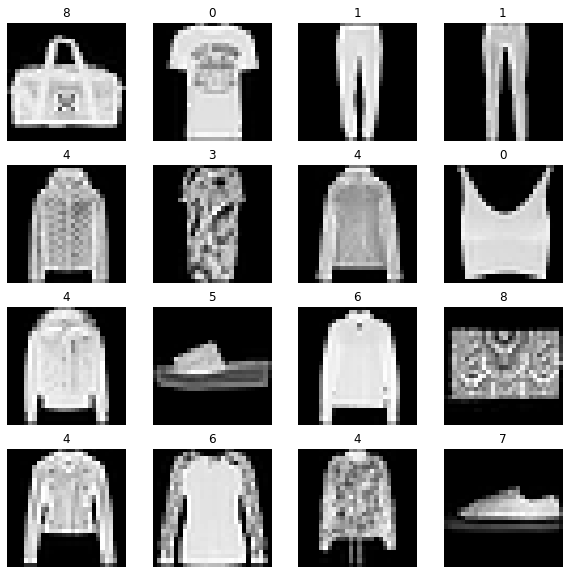

In [153]:
import matplotlib.pyplot as plt
import random

fig, axes = plt.subplots(4, 4, figsize=(10, 10))
for i in range(16):
    index = random.randint(0, len(X_train_full))
    axes[i//4, i%4].imshow(X_train_full[index].reshape(28, 28), cmap='gray')
    axes[i//4, i%4].set_title(y_train_full[index])
    axes[i//4, i%4].axis('off')

2. Train a multilayer perceptron to achieve as good accuracy as you can. There are numerous hyperparameters that we discussed in class which you can tweak, for instance: learning rate, number of and
size of hidden layers, activation function and regularization (e.g. Ridge (known here as L2), and early
stopping). You should make a structured search for the best hyperparameters that you can find.

In [154]:
print(X_train_full.shape, X_train_full.dtype)

(60000, 28, 28) uint8


In [155]:
# rescaling the data down to 0-1 range and creating validation data, since I am going to use gradient descent
X_valid, X_train = X_train_full[:5000] / 255.0, X_train_full[5000:] / 255.0
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.0

In [156]:
# predefined class names from the dataset
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal",
               "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [157]:
def build_model(hp):
    model = keras.models.Sequential([
        keras.layers.Flatten(input_shape=[28, 28]),
        keras.layers.Dense(hp.Int('units', min_value=32, max_value=1024, step=32), activation='relu'),
        keras.layers.Dense(10, activation='softmax')
    ])
    model.compile(loss='sparse_categorical_crossentropy', # since we have sparse labels
              optimizer=keras.optimizers.SGD(learning_rate=hp.Choice('learning_rate', values=[0.1, 0.01, 0.001, 0.0001])), # stochastic gradient descent
              metrics=['accuracy'],
                  batch_size = hp.Choice('batch_size', values=[16, 32, 64]))  # useful to measure accuracy during training
    return model

In [158]:
import keras_tuner as kt
from kerastuner.tuners import RandomSearch
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=3,
    directory='tuner_dir',
    project_name='fashion_mnist_tuning')

INFO:tensorflow:Reloading Tuner from my_dir\helloworld\tuner0.json


In [159]:
tuner.search_space_summary()

Search space summary
Default search space size: 2
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.1, 'conditions': [], 'values': [0.1, 0.01, 0.001], 'ordered': True}


In [160]:
tuner.search(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))

INFO:tensorflow:Oracle triggered exit


In [161]:
tuner.results_summary()

Results summary
Results in my_dir\helloworld
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 3 summary
Hyperparameters:
units: 64
learning_rate: 0.1
Score: 0.8842666745185852

Trial 1 summary
Hyperparameters:
units: 512
learning_rate: 0.01
Score: 0.8739333152770996

Trial 4 summary
Hyperparameters:
units: 384
learning_rate: 0.01
Score: 0.8738666772842407

Trial 0 summary
Hyperparameters:
units: 32
learning_rate: 0.01
Score: 0.8624000151952108

Trial 2 summary
Hyperparameters:
units: 480
learning_rate: 0.001
Score: 0.8300666610399882


In [166]:
tuner.reload()

In [ ]:
best_model = tuner.get_best_models(num_models=1)[0]